###### Imports

In [1]:
import requests
import urllib.request
from zipfile import ZipFile
import json
import io
import zipfile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import pandas as pd
import pysal as ps
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Bring in the TIGER file that we want and examine and clean for use

Specify the zipped shapefile url and read it in with geopandas, then display the info about the geodataframe including the size and datatypes.

In [2]:
#extract GeoDataFrame from Tiger
url= 'https://www2.census.gov/geo/tiger/TIGER2019/CBSA/tl_2019_us_cbsa.zip'
cbsa = gpd.read_file(url)
cbsa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CSAFP     550 non-null    object  
 1   CBSAFP    938 non-null    object  
 2   GEOID     938 non-null    object  
 3   NAME      938 non-null    object  
 4   NAMELSAD  938 non-null    object  
 5   LSAD      938 non-null    object  
 6   MEMI      938 non-null    object  
 7   MTFCC     938 non-null    object  
 8   ALAND     938 non-null    int64   
 9   AWATER    938 non-null    int64   
 10  INTPTLAT  938 non-null    object  
 11  INTPTLON  938 non-null    object  
 12  geometry  938 non-null    geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 95.4+ KB


Look at the crs.

In [3]:
cbsa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Make sure the data looks correct by displaying the head.

In [4]:
cbsa.head()

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,+33.9439840,-083.2138965,"POLYGON ((-83.53739 33.96591, -83.53184 33.968..."
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22494938651,387716575,+33.6937280,-084.3999113,"POLYGON ((-85.33823 33.65312, -85.33842 33.654..."
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,+39.4693555,-074.6337591,"POLYGON ((-74.85675 39.42076, -74.85670 39.420..."
3,426,12120,12120,"Atmore, AL","Atmore, AL Micro Area",M2,2,G3110,2448115116,20504948,+31.1222867,-087.1684097,"POLYGON ((-87.61542 31.04100, -87.61541 31.041..."
4,258,12140,12140,"Auburn, IN","Auburn, IN Micro Area",M2,2,G3110,939731962,2657419,+41.4011894,-085.0001854,"POLYGON ((-85.19295 41.38001, -85.19296 41.381..."


## Bring in the population data using the Census API

###### The data we're curious about comes divided by sex or race - for now we're going to look at sex and then total them together because it's less data to deal with. You are only able to import 50 variables at once, so we're going to do total population and male population together, then female population. Eventually we will join them into one larger dataframe.

For duplication purposes, I'm going to create a list of variables and use string method .format() to iterate through the list to pull all of these variables, then I can copy paste that list into different notebooks where we're looking at different geographies. <-- come back to this... can't get the for loop right for now but ultimately will make it way better.

In [5]:
#male and total
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_015E,B01001_016E,B01001_017E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_001E','B01001_020E','B01001_003E','B01001_004E','B01001_005E','B01001_006E','B01001_007E','B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E','B01001_013E','B01001_014E','B01001_015E','B01001_016E','B01001_017E','B01001_018E','B01001_019E','B01001_020E','B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
male= requests.get(url_str, params= predicates)

col_names = ['CBSA','GEOID','total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
            'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79','m80_84','m85+','ind']
male=pd.DataFrame(columns=col_names, data=male.json()[1:])

In [6]:
male.head()

,CBSA,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,m55_59,m60_61,m62_64,m65_66,m67_69,m70_74,m75_79,m80_84,m85+,ind
0,"Homosassa Springs, FL Metro Area",310M200US26140,139771,67497,2639,2404,3599,2170,1310,544,...,4835,2170,3453,2319,4543,5434,4898,3099,2169,26140
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,363936,180006,10129,11631,11662,7909,5182,2955,...,12607,4571,6761,4305,5277,6744,4547,2959,1922,25860
2,"Hobbs, NM Micro Area",310M200US26020,66876,34219,2909,2708,2964,1522,1137,500,...,1854,696,868,456,626,806,675,448,295,26020
3,"Holland, MI Micro Area",310M200US26090,112266,55910,3599,4145,4271,2617,1315,736,...,4298,1415,1887,1044,1437,1980,1224,935,628,26090
4,"Hood River, OR Micro Area",310M200US26220,22620,11169,800,819,850,381,229,89,...,747,305,368,197,191,459,233,157,122,26220


In [7]:
#female
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B01001_026E,B01001_027E,B01001_028E,B01001_029E,B01001_030E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,B01001_036E,B01001_037E,B01001_038E,B01001_039E,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_026E','B01001_027E','B01001_028E','B01001_029E','B01001_030E','B01001_031E','B01001_032E','B01001_033E','B01001_034E','B01001_035E','B01001_036E','B01001_037E','B01001_038E','B01001_039E','B01001_040E','B01001_041E','B01001_042E','B01001_043E','B01001_044E','B01001_045E','B01001_046E','B01001_047E','B01001_048E','B01001_049E']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
female= requests.get(url_str, params= predicates)

col_names = ['CBSA','GEOID','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29','f30_34',
            'f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74','f75_79','f80_84','f85+','ind']
female=pd.DataFrame(columns=col_names, data=female.json()[1:])

In [8]:
female.head()

,CBSA,GEOID,ftotal,fu5,f5_9,f10_14,f15_17,f18_19,f20,f21,...,f55_59,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,ind
0,"Homosassa Springs, FL Metro Area",310M200US26140,72274,2793,2634,3197,2052,1241,587,719,...,5917,2541,4107,2612,4327,6294,4520,3354,3384,26140
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,183930,9973,10596,12065,6895,4132,2428,2220,...,12833,5074,7537,4340,6002,7976,6162,4219,4500,25860
2,"Hobbs, NM Micro Area",310M200US26020,32657,2881,2747,2692,1509,892,648,378,...,2067,583,803,527,625,898,833,580,392,26020
3,"Holland, MI Micro Area",310M200US26090,56356,3468,3958,3982,2504,1289,654,701,...,3942,1721,1965,1112,1695,1934,1579,946,1319,26090
4,"Hood River, OR Micro Area",310M200US26220,11451,716,742,860,574,154,45,140,...,819,263,326,214,234,419,322,226,316,26220


Join all of these back together into one bigger df

In [9]:
age_pop = pd.merge(male, female, how = 'inner', on = 'GEOID')

In [10]:
age_pop.head()

,CBSA_x,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,f55_59,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,ind_y
0,"Homosassa Springs, FL Metro Area",310M200US26140,139771,67497,2639,2404,3599,2170,1310,544,...,5917,2541,4107,2612,4327,6294,4520,3354,3384,26140
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,363936,180006,10129,11631,11662,7909,5182,2955,...,12833,5074,7537,4340,6002,7976,6162,4219,4500,25860
2,"Hobbs, NM Micro Area",310M200US26020,66876,34219,2909,2708,2964,1522,1137,500,...,2067,583,803,527,625,898,833,580,392,26020
3,"Holland, MI Micro Area",310M200US26090,112266,55910,3599,4145,4271,2617,1315,736,...,3942,1721,1965,1112,1695,1934,1579,946,1319,26090
4,"Hood River, OR Micro Area",310M200US26220,22620,11169,800,819,850,381,229,89,...,819,263,326,214,234,419,322,226,316,26220


Check out our datatypes and any extra columns from the join that are no longer necessary.

In [11]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 928
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CBSA_x  929 non-null    object
 1   GEOID   929 non-null    object
 2   total   929 non-null    object
 3   mtotal  929 non-null    object
 4   mu5     929 non-null    object
 5   m5_9    929 non-null    object
 6   m10_14  929 non-null    object
 7   m15_17  929 non-null    object
 8   m18_19  929 non-null    object
 9   m20     929 non-null    object
 10  m21     929 non-null    object
 11  m22_24  929 non-null    object
 12  m25_29  929 non-null    object
 13  m30_34  929 non-null    object
 14  m35_39  929 non-null    object
 15  m40_44  929 non-null    object
 16  m45_49  929 non-null    object
 17  m50_54  929 non-null    object
 18  m55_59  929 non-null    object
 19  m60_61  929 non-null    object
 20  m62_64  929 non-null    object
 21  m65_66  929 non-null    object
 22  m67_69  929 non-null    ob

Drop the indices and extra CBSA name column, rename the one you're going to keep, then convert all numeric columns to int64 as we're going to be performing mathematical operations on them.

In [12]:
#drop the indices and extra state name
age_pop = age_pop.drop(columns=['ind_x','CBSA_y','ind_y'])

In [13]:
#convert all numeric columns to integers
cols = ['total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+']

age_pop[cols]=age_pop[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [14]:
age_pop = age_pop.rename(columns={'CBSA_x':'CBSA'})

Check that the last few steps were effective.

In [15]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 928
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CBSA    929 non-null    object
 1   GEOID   929 non-null    object
 2   total   929 non-null    int64 
 3   mtotal  929 non-null    int64 
 4   mu5     929 non-null    int64 
 5   m5_9    929 non-null    int64 
 6   m10_14  929 non-null    int64 
 7   m15_17  929 non-null    int64 
 8   m18_19  929 non-null    int64 
 9   m20     929 non-null    int64 
 10  m21     929 non-null    int64 
 11  m22_24  929 non-null    int64 
 12  m25_29  929 non-null    int64 
 13  m30_34  929 non-null    int64 
 14  m35_39  929 non-null    int64 
 15  m40_44  929 non-null    int64 
 16  m45_49  929 non-null    int64 
 17  m50_54  929 non-null    int64 
 18  m55_59  929 non-null    int64 
 19  m60_61  929 non-null    int64 
 20  m62_64  929 non-null    int64 
 21  m65_66  929 non-null    int64 
 22  m67_69  929 non-null    in

Create columns of totals for each one of these age groups.

In [16]:
#create totals columns
age_pop['tu5'] = age_pop['mu5']+age_pop['fu5']
age_pop['t5_9'] = age_pop['m5_9']+age_pop['f5_9']
age_pop['t10_14'] = age_pop['m10_14']+age_pop['f10_14']
age_pop['t15_17'] = age_pop['m15_17']+age_pop['f15_17']
age_pop['t18_19'] = age_pop['m18_19']+age_pop['f18_19']
age_pop['t20'] = age_pop['m20']+age_pop['f20']
age_pop['t21'] = age_pop['m21']+age_pop['f21']
age_pop['t22_24'] = age_pop['m22_24']+age_pop['f22_24']
age_pop['t25_29'] = age_pop['m25_29']+age_pop['f25_29']
age_pop['t30_34'] = age_pop['m30_34']+age_pop['f30_34']
age_pop['t35_39'] = age_pop['m35_39']+age_pop['f35_39']
age_pop['t40_44'] = age_pop['m40_44']+age_pop['f40_44']
age_pop['t45_49'] = age_pop['m45_49']+age_pop['f45_49']
age_pop['t50_54'] = age_pop['m50_54']+age_pop['f50_54']
age_pop['t55_59'] = age_pop['m55_59']+age_pop['f55_59']
age_pop['t60_61'] = age_pop['m60_61']+age_pop['f60_61']
age_pop['t62_64'] = age_pop['m62_64']+age_pop['f62_64']
age_pop['t65_66'] = age_pop['m65_66']+age_pop['f65_66']
age_pop['t67_69'] = age_pop['m67_69']+age_pop['f67_69']
age_pop['t70_74'] = age_pop['m70_74']+age_pop['f70_74']
age_pop['t75_79'] = age_pop['m75_79']+age_pop['f75_79']
age_pop['t80_84'] = age_pop['m80_84']+age_pop['f80_84']
age_pop['t85+'] = age_pop['m85+']+age_pop['f85+']

In [17]:
age_pop.head(3)

,CBSA,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,t50_54,t55_59,t60_61,t62_64,t65_66,t67_69,t70_74,t75_79,t80_84,t85+
0,"Homosassa Springs, FL Metro Area",310M200US26140,139771,67497,2639,2404,3599,2170,1310,544,...,9761,10752,4711,7560,4931,8870,11728,9418,6453,5553
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,363936,180006,10129,11631,11662,7909,5182,2955,...,27358,25440,9645,14298,8645,11279,14720,10709,7178,6422
2,"Hobbs, NM Micro Area",310M200US26020,66876,34219,2909,2708,2964,1522,1137,500,...,4315,3921,1279,1671,983,1251,1704,1508,1028,687


## Create groups for analysis. Since we're looking at ageing services, it makes sense to group people into some rough "stage of life" that is predicated on services provided to them or their position in the workforce.

###### So we're going to do:  
- Under 5: this group needs childcare outside of the public school system  
- Over 5 but under 18: presumably in the school system  
- 18, 19, 20s: out of the school system, likely in college or in the workforce  
- 30s: beginning-mid career  
- 40s: established career  
- 50-64: height of career, then considering retirement  
- 65+: supposedly retiring, officially an older person? what's the term? eligible for medicaid. anyway.

In [18]:
#school is under 18, again for males, females, and total
age_pop['mschool']=age_pop['m5_9']+age_pop['m10_14']+age_pop['m15_17']
age_pop['fschool']=age_pop['f5_9']+age_pop['f10_14']+age_pop['f15_17']
age_pop['tschool']=age_pop['t5_9']+age_pop['t10_14']+age_pop['t15_17']

In [19]:
#18/19/20s
age_pop['m18_20s']=age_pop['m18_19']+age_pop['m20']+age_pop['m21']+age_pop['m22_24']+age_pop['m25_29']
age_pop['f18_20s']=age_pop['f18_19']+age_pop['f20']+age_pop['f21']+age_pop['f22_24']+age_pop['f25_29']
age_pop['t18_20s']=age_pop['t18_19']+age_pop['t20']+age_pop['t21']+age_pop['t22_24']+age_pop['t25_29']

In [20]:
#30s
age_pop['m30s']=age_pop['m30_34']+age_pop['m35_39']
age_pop['f30s']=age_pop['f30_34']+age_pop['f35_39']
age_pop['t30s']=age_pop['t30_34']+age_pop['t35_39']

In [21]:
#40s
age_pop['m40s']=age_pop['m40_44']+age_pop['m45_49']
age_pop['f40s']=age_pop['f40_44']+age_pop['f45_49']
age_pop['t40s']=age_pop['t40_44']+age_pop['t45_49']

In [22]:
#50 - 64
age_pop['m50_65']=age_pop['m50_54']+age_pop['m55_59']+age_pop['m60_61']+age_pop['m62_64']
age_pop['f50_65']=age_pop['f50_54']+age_pop['f55_59']+age_pop['f60_61']+age_pop['f62_64']
age_pop['t50_65']=age_pop['t50_54']+age_pop['t55_59']+age_pop['t60_61']+age_pop['t62_64']

In [23]:
#over 65
age_pop['mo65']=age_pop['m65_66']+age_pop['m67_69']+age_pop['m70_74']+age_pop['m75_79']+age_pop['m80_84']+age_pop['m85+']
age_pop['fo65']=age_pop['f65_66']+age_pop['f67_69']+age_pop['f70_74']+age_pop['f75_79']+age_pop['f80_84']+age_pop['f85+']
age_pop['to65']=age_pop['t65_66']+age_pop['t67_69']+age_pop['t70_74']+age_pop['t75_79']+age_pop['t80_84']+age_pop['t85+']

Make these groups into shares of the total - at this point the data is "highly fragmented" so create a copy of the same name before moving on.

In [25]:
age_pop['Pmschool']=round(age_pop['mschool']*100/age_pop['total'],1)
age_pop['Pfschool']=round(age_pop['fschool']*100/age_pop['total'],1)
age_pop['Ptschool']=round(age_pop['tschool']*100/age_pop['total'],1)
age_pop['Pm18_20s']=round(age_pop['m18_20s']*100/age_pop['total'],1)
age_pop['Pf18_20s']=round(age_pop['f18_20s']*100/age_pop['total'],1)
age_pop['Pt18_20s']=round(age_pop['t18_20s']*100/age_pop['total'],1)
age_pop['Pm30s']=round(age_pop['m30s']*100/age_pop['total'],1)
age_pop['Pf30s']=round(age_pop['f30s']*100/age_pop['total'],1)
age_pop['Pt30s']=round(age_pop['t30s']*100/age_pop['total'],1)
age_pop['Pm40s']=round(age_pop['m40s']*100/age_pop['total'],1)
age_pop['Pf40s']=round(age_pop['f40s']*100/age_pop['total'],1)
age_pop['Pt40s']=round(age_pop['t40s']*100/age_pop['total'],1)
age_pop['Pm50_65']=round(age_pop['m50_65']*100/age_pop['total'],1)
age_pop['Pf50_65']=round(age_pop['f50_65']*100/age_pop['total'],1)
age_pop['Pt50_65']=round(age_pop['t50_65']*100/age_pop['total'],1)
age_pop['Pmo65']=round(age_pop['mo65']*100/age_pop['total'],1)
age_pop['Pfo65']=round(age_pop['fo65']*100/age_pop['total'],1)
age_pop['Pto65']=round(age_pop['to65']*100/age_pop['total'],1)
age_pop = age_pop.copy()

In [26]:
age_pop.head(2)

,CBSA,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,"Homosassa Springs, FL Metro Area",310M200US26140,139771,67497,2639,2404,3599,2170,1310,544,...,7.6,4.9,5.6,10.5,10.8,12.7,23.5,16.1,17.5,33.6
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,363936,180006,10129,11631,11662,7909,5182,2955,...,11.9,7.4,7.3,14.7,10.3,10.8,21.1,7.1,9.1,16.2


Make a separate dataframe of only these created groups and their shares

In [27]:
agegroups = age_pop.drop(columns = ['mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+','tu5','t5_9','t10_14','t15_17','t18_19','t20','t21','t22_24','t25_29',
        't30_34','t35_39','t40_44','t45_49','t50_54','t55_59','t60_61','t62_64','t65_66','t67_69','t70_74',
        't75_79','t80_84','t85+'])

In [28]:
agegroups.head()

,CBSA,GEOID,total,mtotal,ftotal,mschool,fschool,tschool,m18_20s,f18_20s,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,"Homosassa Springs, FL Metro Area",310M200US26140,139771,67497,72274,8173,7883,16056,6988,6343,...,7.6,4.9,5.6,10.5,10.8,12.7,23.5,16.1,17.5,33.6
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,363936,180006,183930,31202,29556,60758,26522,24083,...,11.9,7.4,7.3,14.7,10.3,10.8,21.1,7.1,9.1,16.2
2,"Hobbs, NM Micro Area",310M200US26020,66876,34219,32657,7194,6948,14142,6207,5476,...,13.6,6.3,5.4,11.7,8.4,8.3,16.7,4.9,5.8,10.7
3,"Holland, MI Micro Area",310M200US26090,112266,55910,56356,11033,10444,21477,7422,7258,...,11.7,7.1,7.0,14.1,10.8,10.8,21.6,6.5,7.6,14.1
4,"Hood River, OR Micro Area",310M200US26220,22620,11169,11451,2050,2176,4226,1641,1481,...,12.3,7.9,6.9,14.8,10.1,10.1,20.1,6.0,7.7,13.7


Before the export and the joining, we need to split the full GEOID so that we have the CBSA FIPS, let's also split up the CBSA names so that we have the name, state, and Metro or Micro Area designation. Start with the geography name.

In [29]:
# Split the CBSA column at the comma then name the new column as the first column you index into
name = agegroups['CBSA'].str.split(pat = ',', expand = True)
name

,0,1
0,Homosassa Springs,FL Metro Area
1,Hickory-Lenoir-Morganton,NC Metro Area
2,Hobbs,NM Micro Area
3,Holland,MI Micro Area
4,Hood River,OR Micro Area
...,...,...
924,Mayfield,KY Micro Area
925,Maysville,KY Micro Area
926,McAlester,OK Micro Area
927,McAllen-Edinburg-Mission,TX Metro Area


In [30]:
agegroups['Name'] = name[0]
state_area = name[1]
state_area

0       FL Metro Area
1       NC Metro Area
2       NM Micro Area
3       MI Micro Area
4       OR Micro Area
            ...      
924     KY Micro Area
925     KY Micro Area
926     OK Micro Area
927     TX Metro Area
928     MS Micro Area
Name: 1, Length: 929, dtype: object

In [31]:
# Next we can split this again after the first two figures which indicate the State
state = state_area.str.slice(stop = 3)
state

0       FL
1       NC
2       NM
3       MI
4       OR
      ... 
924     KY
925     KY
926     OK
927     TX
928     MS
Name: 1, Length: 929, dtype: object

In [32]:
agegroups['State'] = state

There are already two other designations for the type of area (M1/M2, 1/2), so we don't need a new column there.

Now we're going to split the GEOIDs.

In [35]:
agegroups['CBSAFIPS'] = agegroups['GEOID'].str.slice(start = 9)

In [36]:
agegroups.head()

,CBSA,GEOID,total,mtotal,ftotal,mschool,fschool,tschool,m18_20s,f18_20s,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,CBSAFIPS
0,"Homosassa Springs, FL Metro Area",310M200US26140,139771,67497,72274,8173,7883,16056,6988,6343,...,10.5,10.8,12.7,23.5,16.1,17.5,33.6,Homosassa Springs,FL,26140
1,"Hickory-Lenoir-Morganton, NC Metro Area",310M200US25860,363936,180006,183930,31202,29556,60758,26522,24083,...,14.7,10.3,10.8,21.1,7.1,9.1,16.2,Hickory-Lenoir-Morganton,NC,25860
2,"Hobbs, NM Micro Area",310M200US26020,66876,34219,32657,7194,6948,14142,6207,5476,...,11.7,8.4,8.3,16.7,4.9,5.8,10.7,Hobbs,NM,26020
3,"Holland, MI Micro Area",310M200US26090,112266,55910,56356,11033,10444,21477,7422,7258,...,14.1,10.8,10.8,21.6,6.5,7.6,14.1,Holland,MI,26090
4,"Hood River, OR Micro Area",310M200US26220,22620,11169,11451,2050,2176,4226,1641,1481,...,14.8,10.1,10.1,20.1,6.0,7.7,13.7,Hood River,OR,26220


## Export this file if you want before joining for statistical analysis or to join to a geodataframe of current year.

In [58]:
agegroups.to_csv('../output/csv/agegroups_2014_cbsa.csv', index = False)

## Join the geodataframe so that we can perform spatial analysis.

In [38]:
agegroups_geo = cbsa.merge(agegroups, left_on='CBSAFP', right_on='CBSAFIPS')

In [39]:
agegroups_geo.head(3)

,CSAFP,CBSAFP,GEOID_x,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,CBSAFIPS
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,...,11.6,7.6,8.3,15.9,4.7,6.3,10.9,Athens-Clarke County,GA,12020
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22494938651,387716575,...,15.4,8.6,9.5,18.0,4.2,5.7,9.9,Atlanta-Sandy Springs-Roswell,GA,12060
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,...,14.5,10.3,11.0,21.3,6.5,8.5,14.9,Atlantic City-Hammonton,NJ,12100


In [40]:
agegroups_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 907 entries, 0 to 906
Data columns (total 57 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CSAFP     529 non-null    object  
 1   CBSAFP    907 non-null    object  
 2   GEOID_x   907 non-null    object  
 3   NAME      907 non-null    object  
 4   NAMELSAD  907 non-null    object  
 5   LSAD      907 non-null    object  
 6   MEMI      907 non-null    object  
 7   MTFCC     907 non-null    object  
 8   ALAND     907 non-null    int64   
 9   AWATER    907 non-null    int64   
 10  INTPTLAT  907 non-null    object  
 11  INTPTLON  907 non-null    object  
 12  geometry  907 non-null    geometry
 13  CBSA      907 non-null    object  
 14  GEOID_y   907 non-null    object  
 15  total     907 non-null    int64   
 16  mtotal    907 non-null    int64   
 17  ftotal    907 non-null    int64   
 18  mschool   907 non-null    int64   
 19  fschool   907 non-null    int64   
 20  ts

Seeing that there are some null values in CSAFP, let's check what those rows look like

In [41]:
nullcsa = agegroups_geo[agegroups_geo['CSAFP'].isnull()]

In [42]:
nullcsa.head(3)

,CSAFP,CBSAFP,GEOID_x,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,...,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State,CBSAFIPS
6,None,12260,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,G3110,9015028913,262514053,...,13.1,9.5,10.5,19.9,5.8,7.6,13.4,Augusta-Richmond County,GA,12260
7,None,12300,12300,"Augusta-Waterville, ME","Augusta-Waterville, ME Micro Area",M2,2,G3110,2246734973,216795650,...,14.1,11.6,12.3,23.8,7.4,9.1,16.5,Augusta-Waterville,ME,12300
9,None,12420,12420,"Austin-Round Rock-Georgetown, TX","Austin-Round Rock-Georgetown, TX Metro Area",M1,1,G3110,10935038512,150326847,...,14.2,8.1,8.4,16.5,3.9,4.9,8.8,Austin-Round Rock,TX,12420


This just means that those geographies are <i>not</i> combined statistical areas, so we're all good and we can move on to renaming and dropping some columns that we don't need.

In [44]:
agegroups_geo = agegroups_geo.drop(columns=['NAMELSAD', 'GEOID_x', 'CBSAFIPS'])
agegroups_geo = agegroups_geo.rename(columns={'NAME':'FullName', 'LSAD':'MetroMicro'})

In [45]:
agegroups_geo.head()

,CSAFP,CBSAFP,FullName,MetroMicro,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,...,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65,Name,State
0,122,12020,"Athens-Clarke County, GA",M1,1,G3110,2654601832,26140309,+33.9439840,-083.2138965,...,5.8,11.6,7.6,8.3,15.9,4.7,6.3,10.9,Athens-Clarke County,GA
1,122,12060,"Atlanta-Sandy Springs-Alpharetta, GA",M1,1,G3110,22494938651,387716575,+33.6937280,-084.3999113,...,7.9,15.4,8.6,9.5,18.0,4.2,5.7,9.9,Atlanta-Sandy Springs-Roswell,GA
2,428,12100,"Atlantic City-Hammonton, NJ",M1,1,G3110,1438776649,301268696,+39.4693555,-074.6337591,...,7.5,14.5,10.3,11.0,21.3,6.5,8.5,14.9,Atlantic City-Hammonton,NJ
3,258,12140,"Auburn, IN",M2,2,G3110,939731962,2657419,+41.4011894,-085.0001854,...,6.4,13.3,10.5,10.3,20.8,6.0,7.9,14.0,Auburn,IN
4,532,12180,"Auburn, NY",M2,2,G3110,1791190510,445708165,+43.0085456,-076.5745866,...,6.8,14.9,11.3,10.9,22.3,7.2,9.0,16.2,Auburn,NY


## Export this file if you want so that we can create maps in another notebook.

In [46]:
#agegroups_geo.to_file('../output/shapefiles/2014_CBSA/2014CBSA.shp')

### Make some quick maps:

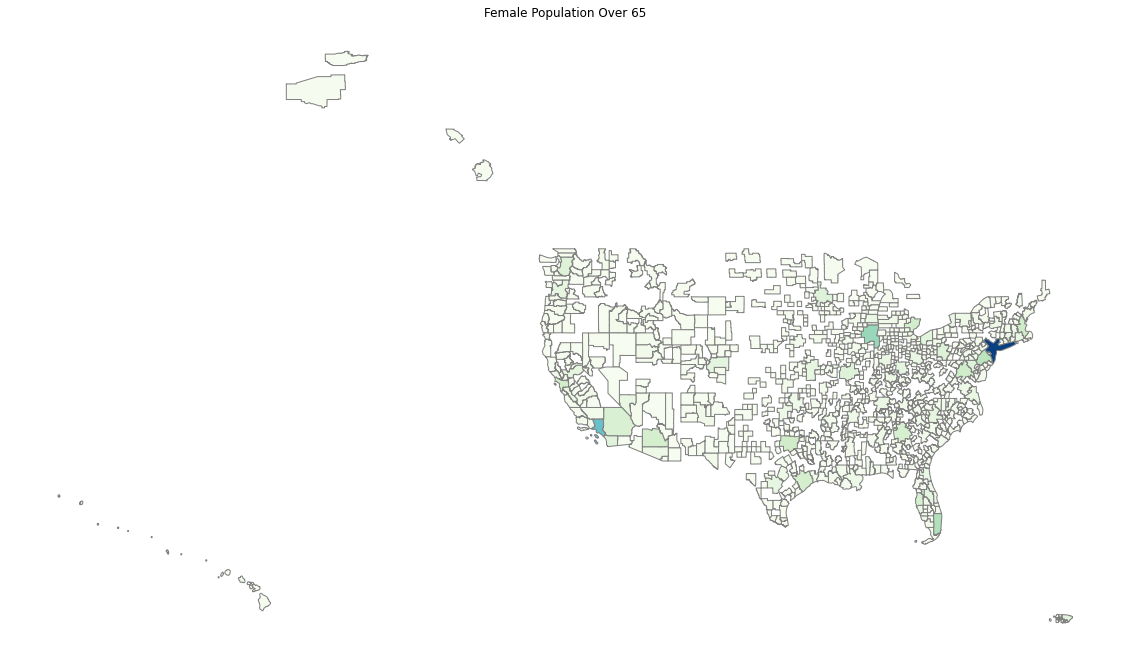

In [56]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'fo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'grey',
                  ax = ax)
plt.title('Female Population Over 65', fontsize=12)
ax.axis('off');

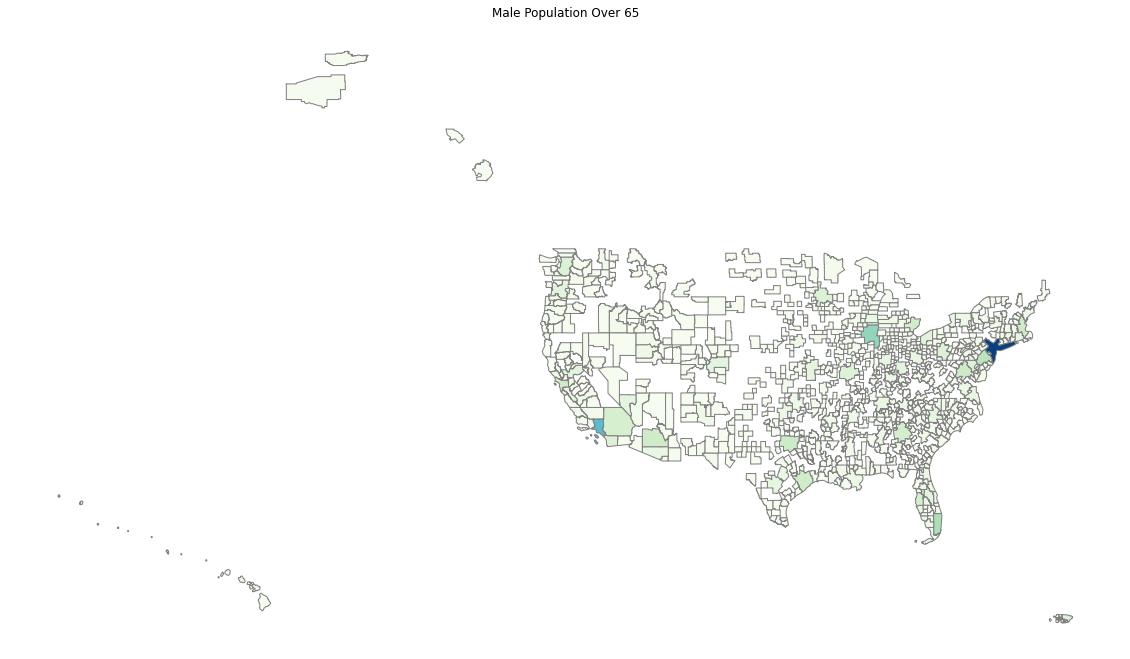

In [50]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'mo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'grey',
                  ax = ax)
plt.title('Male Population Over 65', fontsize=12)
ax.axis('off');

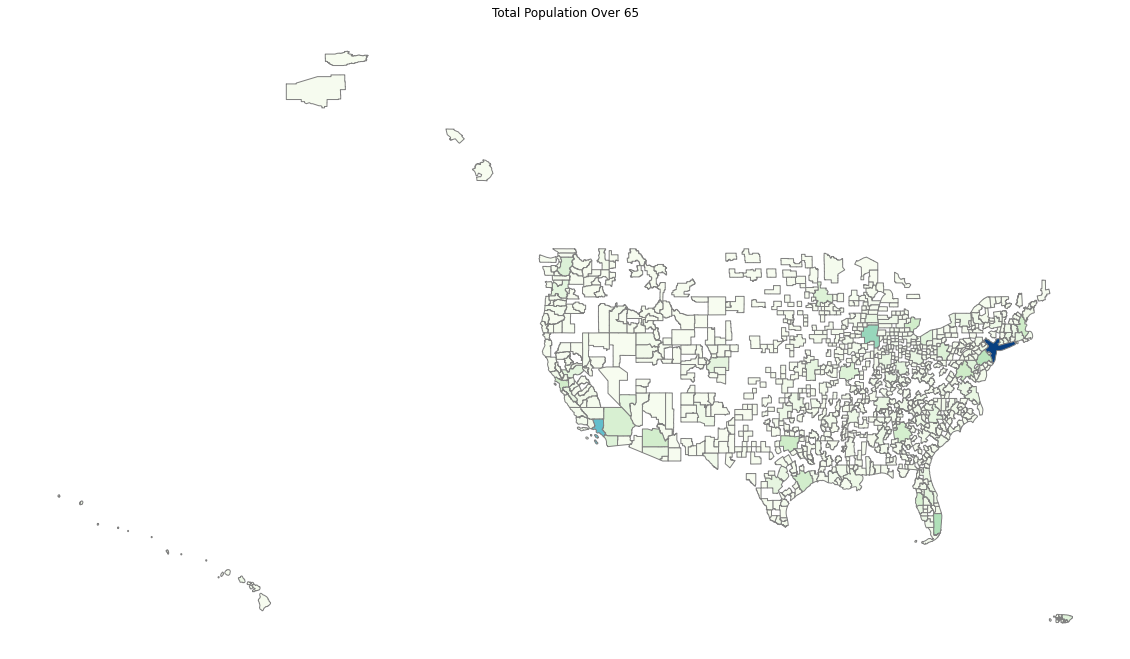

In [51]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'to65', 
                  cmap = 'GnBu', 
                  edgecolor = 'grey',
                  ax = ax)
plt.title('Total Population Over 65', fontsize=12)
ax.axis('off');

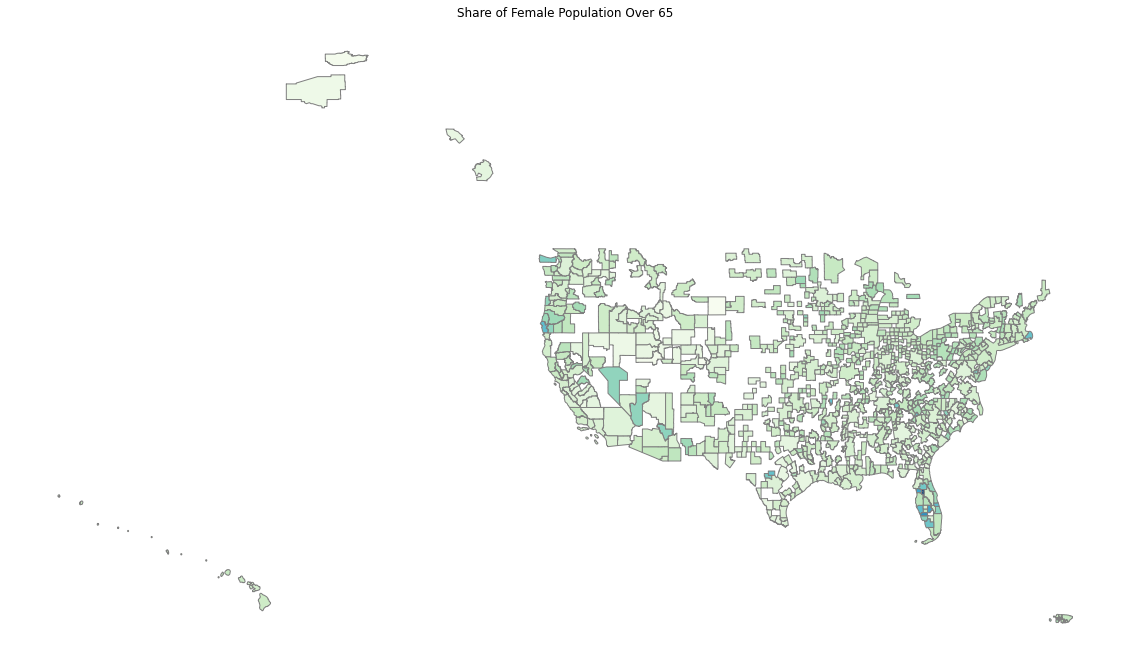

In [52]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pfo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'grey',
                  ax = ax)
plt.title('Share of Female Population Over 65', fontsize=12)
ax.axis('off');

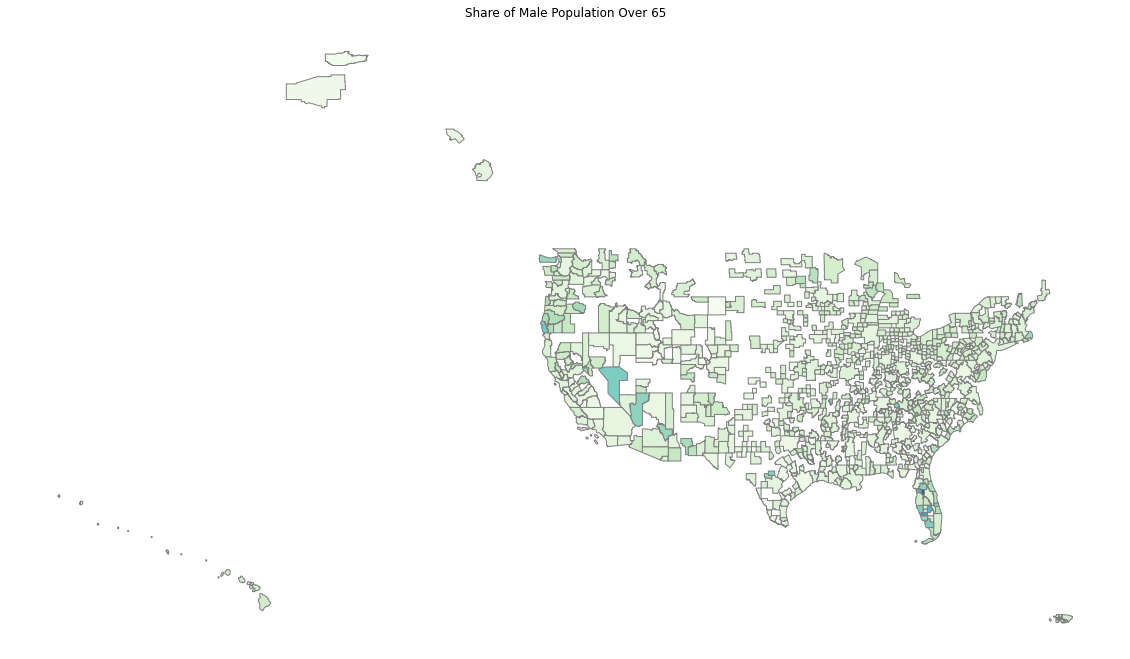

In [53]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pmo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'grey',
                  ax = ax)
plt.title('Share of Male Population Over 65', fontsize=12)
ax.axis('off');

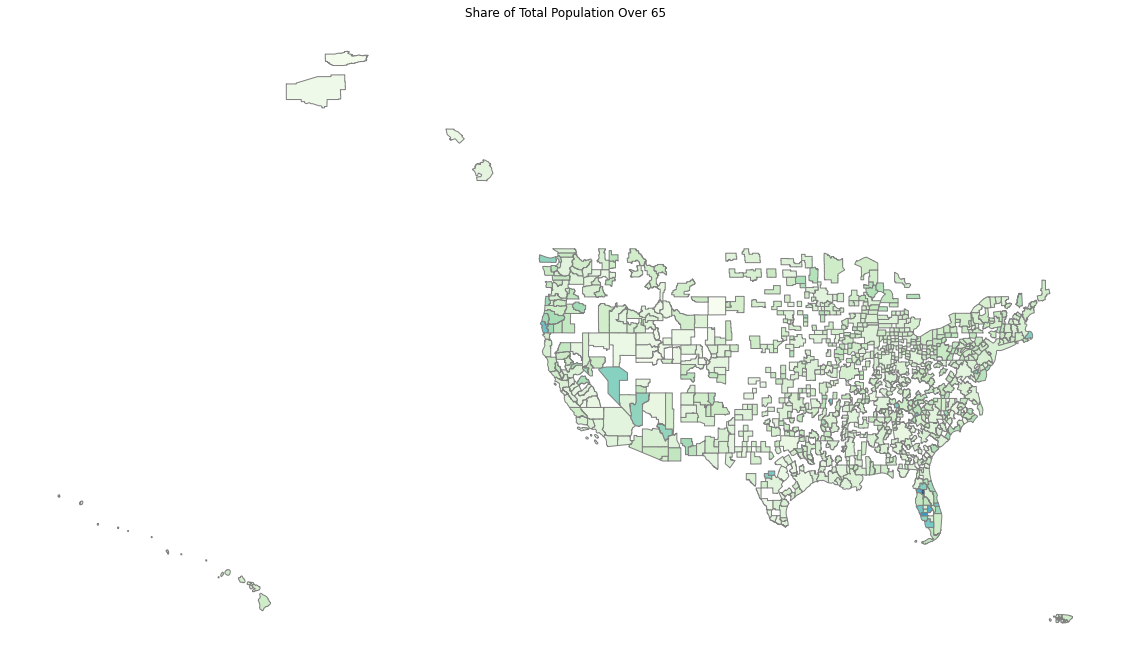

In [54]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pto65', 
                  cmap = 'GnBu', 
                  edgecolor = 'grey',
                  ax = ax)
plt.title('Share of Total Population Over 65', fontsize=12)
ax.axis('off');